## NLLS (Non-Linear Least Square)

- 对比经典的 OLS（Ordinary Least Square）应用在线性模型上，NNLS 对建模没有线性的要求；
- 两者目标函数的是相同的，即最小化 squared error

$$
\begin{split}
S&=\sum_{i=1}^mr_i^2\\
&=\sum_{i=1}^m\left(y_i-f(x_i,\beta)\right)^2
\end{split}
$$

- 在优化方法上，依然是梯度方法

$$
\frac{\partial S}{\partial \beta_j}=2\sum_i r_i\frac{\partial r_i}{\partial \beta_j}=0, \quad j=1,\cdots,n
$$

- Iterative optimization procedures for estimating parameters
    $$
    \beta_j\approx \beta_j^{k+1}=\beta_j^k+\Delta \beta_j
    $$
- User provided starting values
- Bad starting values may converge to local minima instead of global minima
- String sensitivity to outliers

```
# residuals^2
def error(params, x, y):
    return np.sum((func(x, params) - y)**2)
```

## scipy api

> scipy.optimize 几乎涵盖了一部大部头的《数值优化》的算法实现；

- `scipy.optimize.leastsq(func, x0, args=(),`
    - Minimize the sum of squares of a set of equations.
    - 第一个参数 `func` 是 error function
    - A legacy wrapper for the MINPACK implementation of the Levenberg-Marquadt algorithm.
- `scipy.optimize.least_squares(fun, x0, ...)`
    - 第一个参数 `fun` 也是 error function
    - Solve a **nonlinear least-squares** problem with **bounds** on the variables.
    
    ```
    minimize F(x) = 0.5 * sum(rho(f_i(x)**2), i = 0, ..., m - 1)
    subject to lb <= x <= ub
    ```
    
- `scipy.optimize.curve_fit(f, xdata, ydata, ...)`
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    - Use **non-linear least squares** to fit a function, f, to data.
    - `ydata = f(xdata, *params) + eps.`
    - method{‘lm’, ‘trf’, ‘dogbox’}, optional
        - Default is ‘lm’ for unconstrained problems: **Levenberg–Marquardt algorithm**
        - and ‘trf’ if bounds are provided. 
        - The method ‘lm’ won’t work when the number of observations is less than the number of variables, use ‘trf’ or ‘dogbox’ in this case.
    - 返回值方面
        - popt
        - pcov
            - 方差越大，不确定性越高；
            -  Covariance matrices with large condition numbers (e.g. computed with `numpy.linalg.cond`) may indicate that results are unreliable.
            - `perr = np.sqrt(np.diag(pcov))`


- In some cases, writing an explicit function to compute the Jacobian is faster than letting leastsq estimate it numerically. Create a function to compute the Jacobian of the residuals and use it as an input for leastsq.

```
# curve_fit

if method == 'lm':
    ...
    res = leastsq(func, p0, Dfun=jac, full_output=1, **kwargs)
    ...
else:
   ...
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
                        **kwargs)
   ...
```

## examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

$$
f(x,\beta)=a\exp(-bx)+c, \quad \beta=(a,b,c)
$$

In [2]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

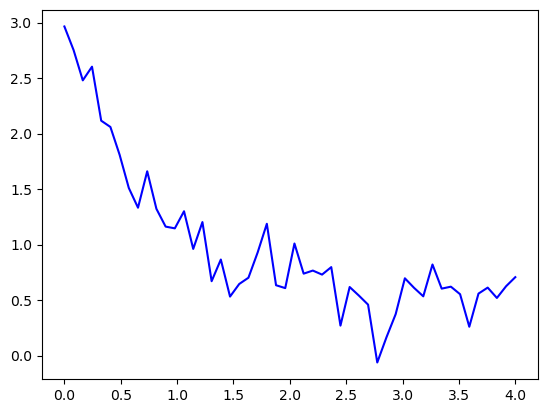

In [3]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
# (xdata, ydata): samples or observations
plt.plot(xdata, ydata, 'b-', label='data')

In [6]:
len(xdata)

50

In [54]:
popt, pcov, infodict, _, _ = curve_fit(func, xdata, ydata, full_output=True)

In [55]:
popt

array([2.5387471 , 1.366168  , 0.50650488])

In [56]:
pcov

array([[ 0.01493892,  0.0065579 , -0.00069432],
       [ 0.0065579 ,  0.01942262,  0.00505906],
       [-0.00069432,  0.00505906,  0.0025907 ]])

In [28]:
infodict['nfev']

21

In [18]:
len(infodict['fvec'])

50

In [23]:
np.allclose(func(xdata, *popt) - ydata, infodict['fvec'])

True

In [27]:
# n*m
infodict['fjac'].shape

(3, 50)

### jac

In [33]:
np.hstack([np.ones((2, )), 2*np.ones((3, ))])

array([1., 1., 2., 2., 2.])

In [51]:
def jac(xdata, a, b, c):
    # return m*n array, m: num of samples, n: num of parameters
#     print(xdata.shape)
#     print(np.exp(-b*xdata)[:, None].shape)
#     print(((-a*xdata*np.exp(-b*xdata))[:, None]).shape)
    return np.hstack([np.exp(-b*xdata)[:, None], 
                      (-a*(xdata*np.exp(-b*xdata)))[:, None], 
                      1*np.ones_like(xdata)[:, None]])

In [57]:
popt, pcov, infodict, _, _ = curve_fit(func, xdata, ydata, full_output=True, jac=jac)

In [58]:
popt

array([2.5387471 , 1.36616799, 0.50650488])

In [59]:
pcov

array([[ 0.01493892,  0.0065579 , -0.00069432],
       [ 0.0065579 ,  0.01942262,  0.00505906],
       [-0.00069432,  0.00505906,  0.0025907 ]])

In [61]:
infodict['nfev']

6

### bounds

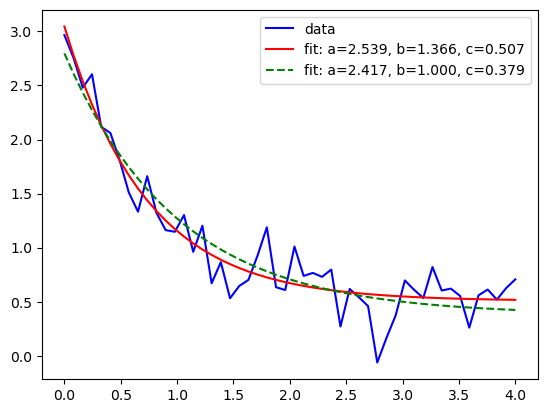

In [66]:
plt.plot(xdata, ydata, 'b-', label='data')
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.legend()

### pcov

In [69]:
popt, pcov = curve_fit(func, xdata, ydata)

In [71]:
pcov

array([[ 0.01493892,  0.0065579 , -0.00069432],
       [ 0.0065579 ,  0.01942262,  0.00505906],
       [-0.00069432,  0.00505906,  0.0025907 ]])

In [70]:
np.linalg.cond(pcov)

34.755088022071746

In [75]:
# overparametered
def func(x, a, b, c, d):
    return a * d * np.exp(-b * x) + c  # a and d are redundant

In [73]:
popt, pcov = curve_fit(func, xdata, ydata)
pcov

array([[ 1.18968219e+28, -4.16750247e+12, -4.60753886e+12,
        -2.70684190e+28],
       [-4.16750247e+12,  2.13058405e-02,  6.78306728e-03,
         9.48217134e+12],
       [-4.60753886e+12,  6.78306728e-03,  4.43138755e-03,
         1.04833706e+13],
       [-2.70684190e+28,  9.48217134e+12,  1.04833706e+13,
         6.15878188e+28]])

In [74]:
np.linalg.cond(pcov)

6.05823456132018e+31

## 分段线性拟合

In [2]:

from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 90, 80, 70, 60])

def piecewise_linear(x, y0, y1, b0, b1, b2):
    x0 = 6
    x1 = 12
    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0,          # (x0, b0x0+y0)
                         lambda x: b1*x + y1-b1*x1,    # (x0, b1(x0-x1)+y1), (x1, y1)
                         lambda x: b2*x + y1-b2*x1])   # (x1, y1)

In [3]:
p, e = optimize.curve_fit(piecewise_linear, x, y)

In [4]:
p

array([  3.        ,  93.74127658,   2.        ,  12.82392098,
       -11.60340422])

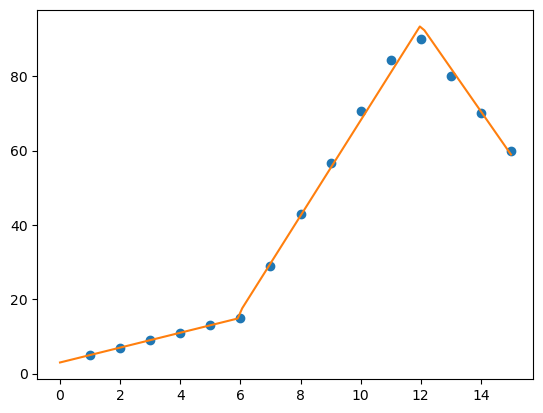

In [5]:
new_x = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(new_x, piecewise_linear(new_x, *p))